<a href="https://colab.research.google.com/github/lilfetz22/Health_Scores_CAP2/blob/master/scripts/Health_Scores_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Health Scores Exploratory Data Analysis

An exploration of the dataset. Several manipulations of data to mainly impute missing values, handle the outliers and scale the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import quilt3
import missingno as msno
import random
import tqdm as tqdm
from scipy.stats import iqr, shapiro, anderson, normaltest
from fancyimpute import KNN, SoftImpute, BiScaler
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import (OneHotEncoder, StandardScaler, Normalizer, 
                                   QuantileTransformer, RobustScaler, 
                                   PowerTransformer,minmax_scale,MaxAbsScaler,
                                   MinMaxScaler)

city_data = pd.read_csv('../data/raw_data/CHDB_data_city_all v7_1.csv')
tract_data = pd.read_csv('../data/raw_data/CHDB_data_tract_all v7_1(big).csv')
city_data.head()

Using TensorFlow backend.
C:\Users\Billy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,state_abbr,state_fips,place_fips,stpl_fips,city_name,metric_name,group_name,metric_number,group_number,num,...,lci,uci,county_indicator,educ_indicator,multiplier_indicator,data_yr_type,geo_level,date_export,version,NOTE - NCHS Disclaimer
0,HI,15,3,15003,Honolulu,Absenteeism,total population,1,1,9625.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,2015-2016,city,9/26/2019,7.1,The downloadable data tables shared on the Cit...
1,AL,1,7000,107000,Birmingham,Absenteeism,total population,1,1,2250.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,2015-2016,city,9/26/2019,7.1,NaN
2,AL,1,35896,135896,Hoover,Absenteeism,total population,1,1,1517.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,2015-2016,city,9/26/2019,7.1,NaN
3,AL,1,37000,137000,Huntsville,Absenteeism,total population,1,1,2376.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,2015-2016,city,9/26/2019,7.1,NaN
4,AL,1,50000,150000,Mobile,Absenteeism,total population,1,1,2826.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,2015-2016,city,9/26/2019,7.1,NaN


In [0]:
tract_data.head()

,state_abbr,state_fips,county_fips,county_name,tract_code,stcotr_fips,city_name,metric_name,metric_number,group_name,group_number,num,denom,est,lci,uci,data_yr_type,geo_level,date_export,version
0,HI,15,3,Honolulu County,106,15003000106,Honolulu,Air pollution - particulate matter,2,total population,1,-999.0,-999.0,NaN,-999.0,-999.0,2015,tract,9/19/2019,7.1
1,HI,15,3,Honolulu County,107,15003000107,Honolulu,Air pollution - particulate matter,2,total population,1,-999.0,-999.0,NaN,-999.0,-999.0,2015,tract,9/19/2019,7.1
2,HI,15,3,Honolulu County,108,15003000108,Honolulu,Air pollution - particulate matter,2,total population,1,-999.0,-999.0,NaN,-999.0,-999.0,2015,tract,9/19/2019,7.1
3,HI,15,3,Honolulu County,110,15003000110,Honolulu,Air pollution - particulate matter,2,total population,1,-999.0,-999.0,NaN,-999.0,-999.0,2015,tract,9/19/2019,7.1
4,HI,15,3,Honolulu County,111,15003000111,Honolulu,Air pollution - particulate matter,2,total population,1,-999.0,-999.0,NaN,-999.0,-999.0,2015,tract,9/19/2019,7.1


In [2]:
tract_data_names = tract_data.loc[:, ['county_name', 	'tract_code', 	'stcotr_fips', 'city_name','state_abbr']] 
tract_data_names.to_csv('../data/manipulated_data/tract_state_names.csv')

In [0]:
print(city_data.shape)
tract_data.shape

(60500, 22)


(631295, 20)

In [0]:
print(city_data.columns.values)
tract_data.columns.values

['state_abbr' 'state_fips' 'place_fips' 'stpl_fips' 'city_name'
 'metric_name' 'group_name' 'metric_number' 'group_number' 'num' 'denom'
 'est' 'lci' 'uci' 'county_indicator' 'educ_indicator'
 'multiplier_indicator' 'data_yr_type' 'geo_level' 'date_export' 'version'
 'NOTE - NCHS Disclaimer']


array(['state_abbr', 'state_fips', 'county_fips', 'county_name',
       'tract_code', 'stcotr_fips', 'city_name', 'metric_name',
       'metric_number', 'group_name', 'group_number', 'num', 'denom',
       'est', 'lci', 'uci', 'data_yr_type', 'geo_level', 'date_export',
       'version'], dtype=object)

In [3]:
possiblenas = ['', -999] # possible nas in the dataset
def na_replace(df, nas):
    ''' simple function that replaces all missing values in dataframe with NaN 
    values
    '''
    df2 = df.replace(to_replace=nas,value=np.nan)
    return(df2)

In [4]:
city_data = na_replace(city_data, possiblenas)
tract_data = na_replace(tract_data, possiblenas)

In [0]:
print(city_data.info())
tract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60500 entries, 0 to 60499
Data columns (total 22 columns):
state_abbr                60500 non-null object
state_fips                60500 non-null int64
place_fips                60500 non-null int64
stpl_fips                 60500 non-null int64
city_name                 60500 non-null object
metric_name               60500 non-null object
group_name                60500 non-null object
metric_number             60500 non-null int64
group_number              60500 non-null int64
num                       19421 non-null float64
denom                     19421 non-null float64
est                       54485 non-null float64
lci                       46560 non-null float64
uci                       46560 non-null float64
county_indicator          49185 non-null float64
educ_indicator            4386 non-null float64
multiplier_indicator      15717 non-null float64
data_yr_type              60302 non-null object
geo_level                

In [0]:
print(city_data.describe())
tract_data.describe()

        state_fips    place_fips     stpl_fips  metric_number  group_number  \
count  60500.00000  60500.000000  6.050000e+04   60500.000000  60500.000000   
mean      23.99600  42356.282000  2.438986e+06      21.578512      4.322314   
std       17.16464  24346.278823  1.718587e+06      11.062463      3.240308   
min        1.00000      3.000000  1.500300e+04       1.000000      1.000000   
25%        6.00000  21000.000000  6.700735e+05      11.000000      1.000000   
50%       19.00000  45000.000000  1.955965e+06      25.000000      4.000000   
75%       40.00000  62635.750000  4.053125e+06      30.000000      6.000000   
max       56.00000  88940.000000  5.613900e+06      37.000000     18.000000   

                num         denom           est           lci           uci  \
count  1.942100e+04  1.942100e+04  54485.000000  46560.000000  46560.000000   
mean   1.245721e+04  4.474203e+04    468.094553    513.874839    573.218902   
std    4.803710e+04  1.702946e+05   1815.247036   1

,state_fips,county_fips,tract_code,stcotr_fips,metric_number,group_number,num,denom,est,lci,uci,version
count,631295.000000,631295.000000,631295.000000,6.312950e+05,631295.000000,631295.0,174583.000000,174583.000000,588313.000000,472157.000000,472157.000000,6.312950e+05
mean,25.839156,95.668755,129555.791001,2.593495e+10,14.560999,1.0,703.682496,2471.474353,25.984848,25.404014,31.823865,7.100000e+00
std,16.758504,124.328758,214592.544700,1.680352e+10,8.852314,0.0,1189.729979,1864.095898,24.822515,22.602011,23.814115,3.759129e-11
min,1.000000,1.000000,100.000000,1.073000e+09,2.000000,1.0,0.000000,0.000000,-100.000000,-862.900000,0.000000,7.100000e+00
25%,8.000000,31.000000,4602.000000,8.001009e+09,7.000000,1.0,125.000000,1197.000000,9.600000,9.800000,14.000000,7.100000e+00
50%,26.000000,63.000000,20600.000000,2.608100e+10,14.000000,1.0,318.000000,1982.000000,19.000000,18.500000,24.300000,7.100000e+00
75%,40.000000,109.000000,127600.000000,4.010911e+10,21.000000,1.0,694.000000,3253.000000,36.900000,32.900000,42.900000,7.100000e+00
max,56.000000,810.000000,991703.000000,5.602198e+10,37.000000,1.0,24507.000000,44754.000000,100.000000,100.000000,878.900000,7.100000e+00


In [5]:
# currently only looking at total population level; however, could easily come 
# back here to divide it out
# into demographic data. Which is what group_number represents. 
total_pop = city_data[city_data.group_number == 1]
total_pop_select = total_pop.loc[:, ['stpl_fips','city_name','state_abbr']]
total_pop_select.to_csv('../data/manipulated_data/city_state_names.csv')

city_table = total_pop.pivot(index='stpl_fips',columns='metric_name',
                                    values='est')
print(city_table.info())
city_table.describe()
city_table.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 15003 to 5613900
Data columns (total 36 columns):
Absenteeism                               500 non-null float64
Air pollution - particulate matter        498 non-null float64
Binge drinking                            500 non-null float64
Breast cancer deaths                      492 non-null float64
Cardiovascular disease deaths             494 non-null float64
Children in Poverty                       500 non-null float64
Colorectal cancer deaths                  492 non-null float64
Dental care                               500 non-null float64
Diabetes                                  500 non-null float64
Frequent mental distress                  500 non-null float64
Frequent physical distress                500 non-null float64
High blood pressure                       500 non-null float64
High school graduation                    478 non-null float64
Housing cost, excessive                   500 non-null float64
Housi

metric_name,Absenteeism,Air pollution - particulate matter,Binge drinking,Breast cancer deaths,Cardiovascular disease deaths,Children in Poverty,Colorectal cancer deaths,Dental care,Diabetes,Frequent mental distress,...,Prenatal care,Preventive services,Racial/ethnic diversity,Smoking,Teen births,Third-grade reading proficiency,Unemployment,Uninsured,Violent crime,Walkability
stpl_fips,,,,,,,,,,,,,,,,,,,,,
15003,16.1,NaN,17.7,18.3,146.5,11.3,12.1,72.3,10.3,9.6,...,77.4,30.9,79.7,13.7,17.2,66.7,4.5,4.7,247.2,63.7
107000,21.6,11.5,13.2,42.5,293.8,45.4,25.1,52.6,16.7,15.2,...,66.3,29.5,59.8,22.3,49.4,14.6,10.7,15.9,NaN,39.4
135896,10.4,11.4,17.8,11.9,81.9,8.0,4.1,74.5,8.3,10.4,...,NaN,42.5,56.3,14.1,NaN,53.3,4.2,7.4,97.5,22.6
137000,25.4,10.4,14.1,21.2,171.2,28.7,13.9,61.2,12.2,13.3,...,63.3,43.0,61.6,18.5,22.8,36.2,7.3,13.0,934.5,23.4
150000,18.8,10.3,14.7,29.4,267.1,34.8,19.8,58.7,15.2,14.7,...,82.1,31.3,59.6,20.2,36.6,26.0,7.9,14.7,949.3,32.6


In [0]:
tract_select = tract_data.loc[:, ['stcotr_fips','metric_name','est']]
#there were duplicated values here, but they could just be averaged together, 
# because they were always exactly the same because they were duplicate values 
# for every measure. The reason they were duplicated was because in some cities 
# there are census tracts that go through both cities. For example, census tract 
# 30213 in Alabama is partly in Birmingham, AL and partly in Hoover, AL. Thus, 
# it is repeated for each city, however, they are the same value. 
tract_table =tract_select.pivot_table(index='stcotr_fips', columns='metric_name',
                                      values='est',aggfunc=np.mean)
print(tract_table.info())
tract_table.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28527 entries, 1073000100 to 56021980801
Data columns (total 21 columns):
Air pollution - particulate matter    28231 non-null float64
Binge drinking                        26968 non-null float64
Children in Poverty                   28078 non-null float64
Dental care                           26968 non-null float64
Diabetes                              26968 non-null float64
Frequent mental distress              26968 non-null float64
Frequent physical distress            26968 non-null float64
High blood pressure                   26962 non-null float64
Housing cost, excessive               28262 non-null float64
Housing with potential lead risk      28272 non-null float64
Income Inequality                     28262 non-null float64
Lead exposure risk index              28262 non-null float64
Life expectancy                       25360 non-null float64
Limited access to healthy foods       28293 non-null float64
Obesity               

metric_name,Air pollution - particulate matter,Binge drinking,Children in Poverty,Dental care,Diabetes,Frequent mental distress,Frequent physical distress,High blood pressure,"Housing cost, excessive",Housing with potential lead risk,...,Lead exposure risk index,Life expectancy,Limited access to healthy foods,Obesity,Physical inactivity,Preventive services,Racial/ethnic diversity,Smoking,Unemployment,Uninsured
count,28231.000000,26968.000000,28078.000000,26968.000000,26968.000000,26968.000000,26968.000000,26962.000000,28262.000000,28272.000000,...,28262.000000,25360.000000,28293.000000,26968.000000,26968.000000,26911.000000,28347.000000,26968.000000,28295.000000,28297.000000
mean,9.428958,17.643291,24.052639,61.198369,10.826940,13.123206,12.774074,30.543900,38.123512,23.349335,...,5.565494,78.112275,53.178871,30.125200,25.502816,30.697104,54.793597,18.124871,7.955582,13.470424
std,1.603343,4.152471,20.341042,12.950410,4.292705,3.414342,4.136524,8.305887,12.457684,17.400265,...,2.863762,4.277779,36.950816,8.239648,9.313972,7.387103,20.001796,6.056581,5.746834,8.994300
min,3.600000,3.200000,0.000000,18.900000,0.800000,4.100000,3.200000,4.900000,0.000000,0.000000,...,1.000000,59.000000,0.000000,9.100000,7.100000,6.300000,0.000000,2.000000,0.000000,0.000000
25%,8.400000,15.000000,6.600000,51.300000,7.900000,10.500000,9.600000,25.300000,29.000000,7.300000,...,3.000000,75.500000,15.800000,24.000000,18.100000,24.800000,41.500000,13.600000,4.100000,6.700000
50%,9.500000,17.300000,19.500000,62.800000,10.000000,12.700000,12.100000,29.300000,37.400000,19.800000,...,6.000000,78.500000,58.100000,29.200000,24.200000,30.900000,57.300000,17.300000,6.500000,11.500000
75%,10.600000,19.900000,37.700000,71.700000,13.000000,15.400000,15.500000,34.600000,46.575000,37.700000,...,8.000000,81.100000,89.000000,35.200000,32.000000,36.300000,70.000000,21.800000,10.100000,18.300000
max,16.300000,44.800000,98.300000,88.900000,42.100000,29.400000,35.800000,71.000000,100.000000,68.000000,...,10.000000,94.200000,100.000000,57.500000,62.100000,54.100000,99.200000,51.400000,92.800000,100.000000


# Indexing

In [0]:
# converting the lead exposure risk index into a category since they were valued 
# from 1-10 in the original dataset with 1 being low risk and 10 being high risk
city_table['Lead exposure risk index'] = city_table['Lead exposure risk index'].astype('category')
tract_table['Lead exposure risk index'] = tract_table['Lead exposure risk index'].astype('category')
city_table.index = city_table.index.astype(str)
tract_table.index = tract_table.index.astype(str)

# Missing Values Visualization

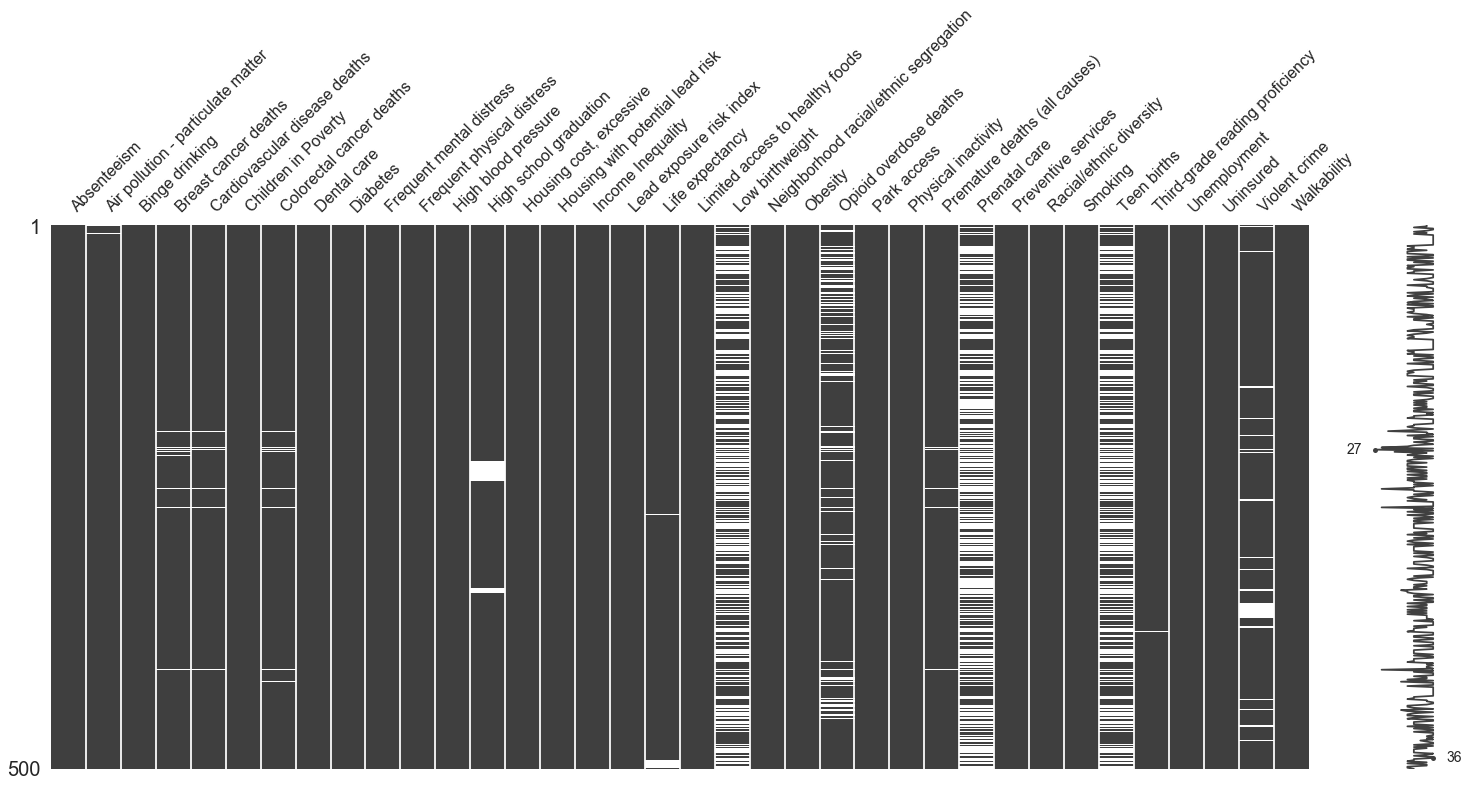

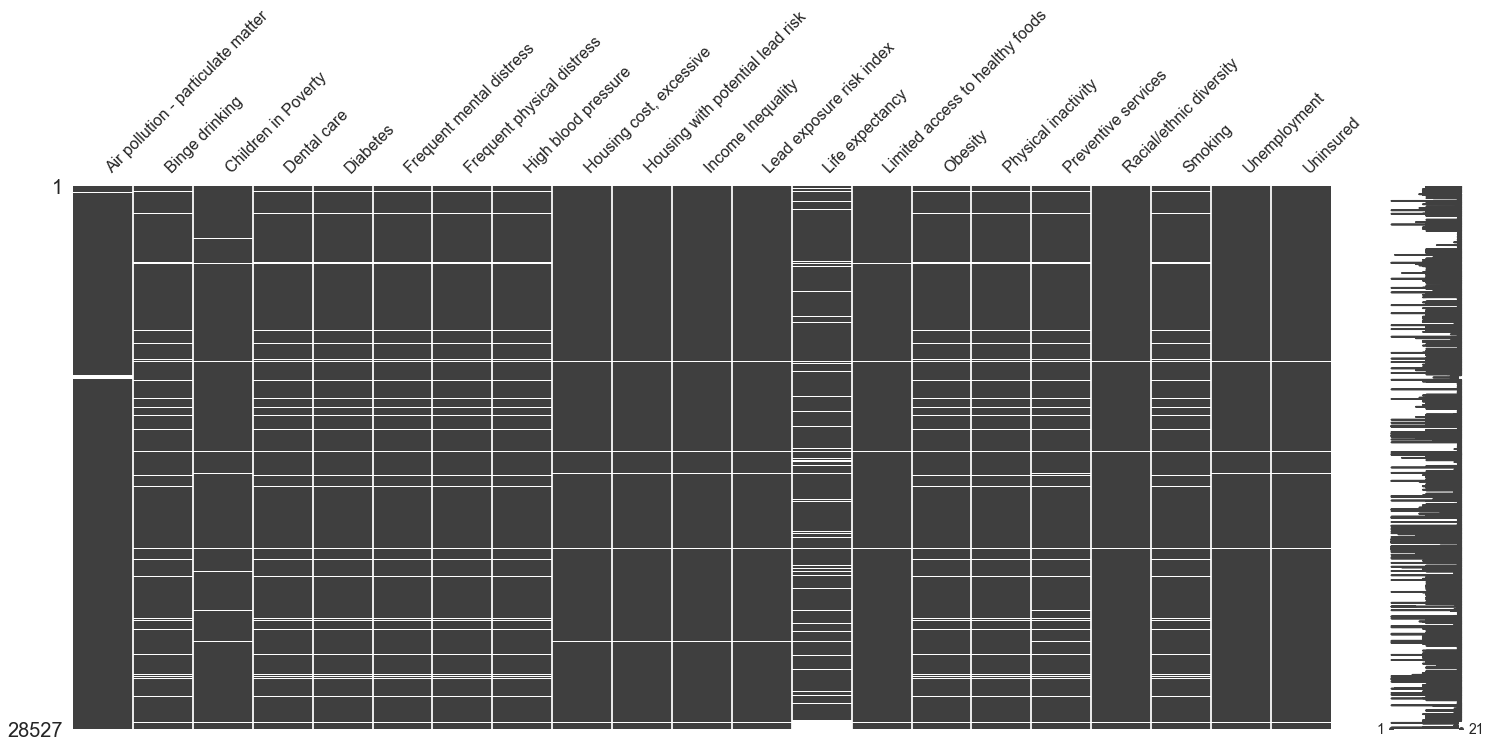

In [0]:
msno.matrix(city_table)
msno.matrix(tract_table)

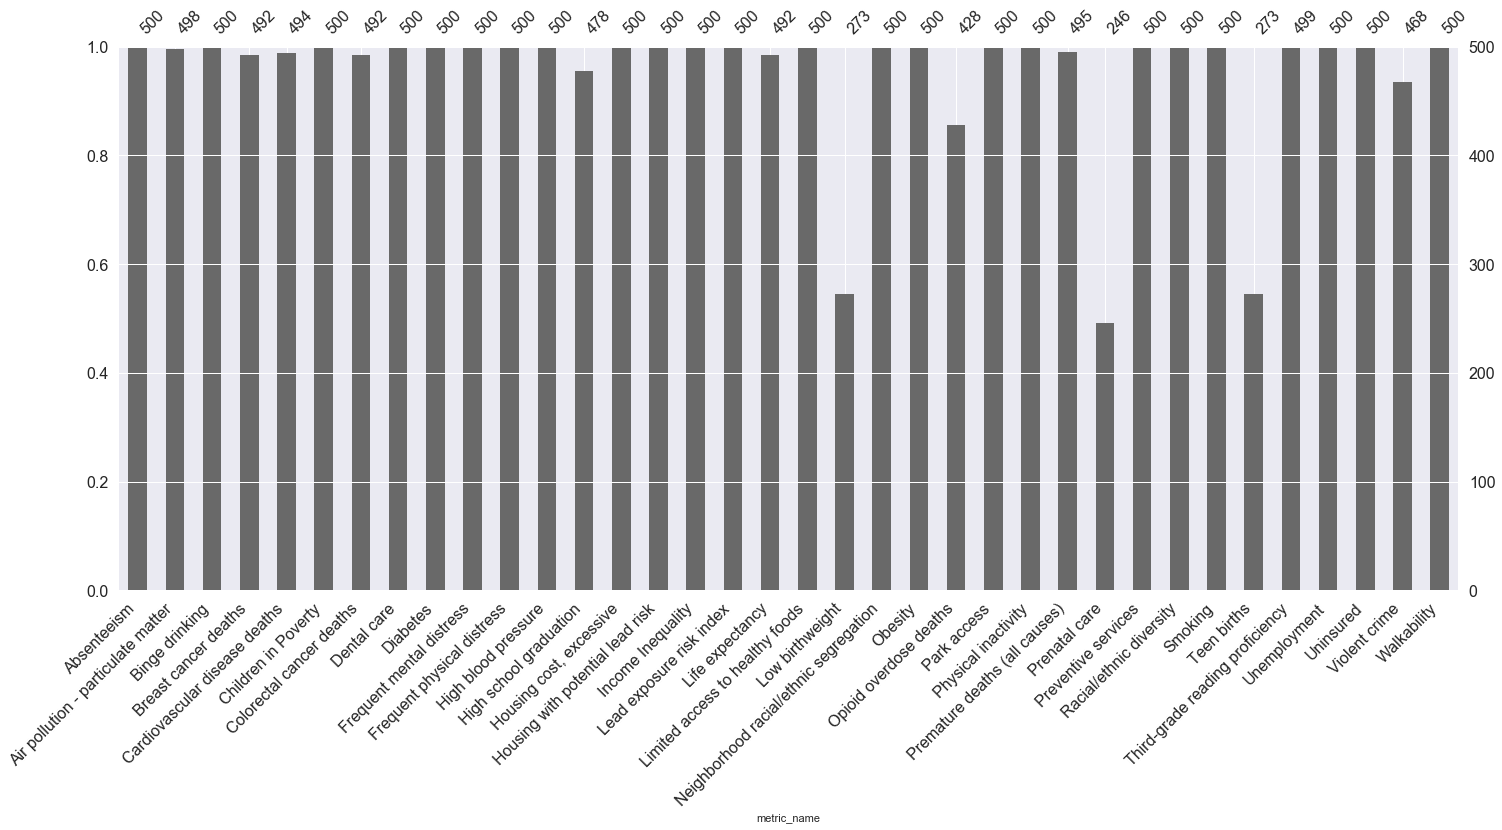

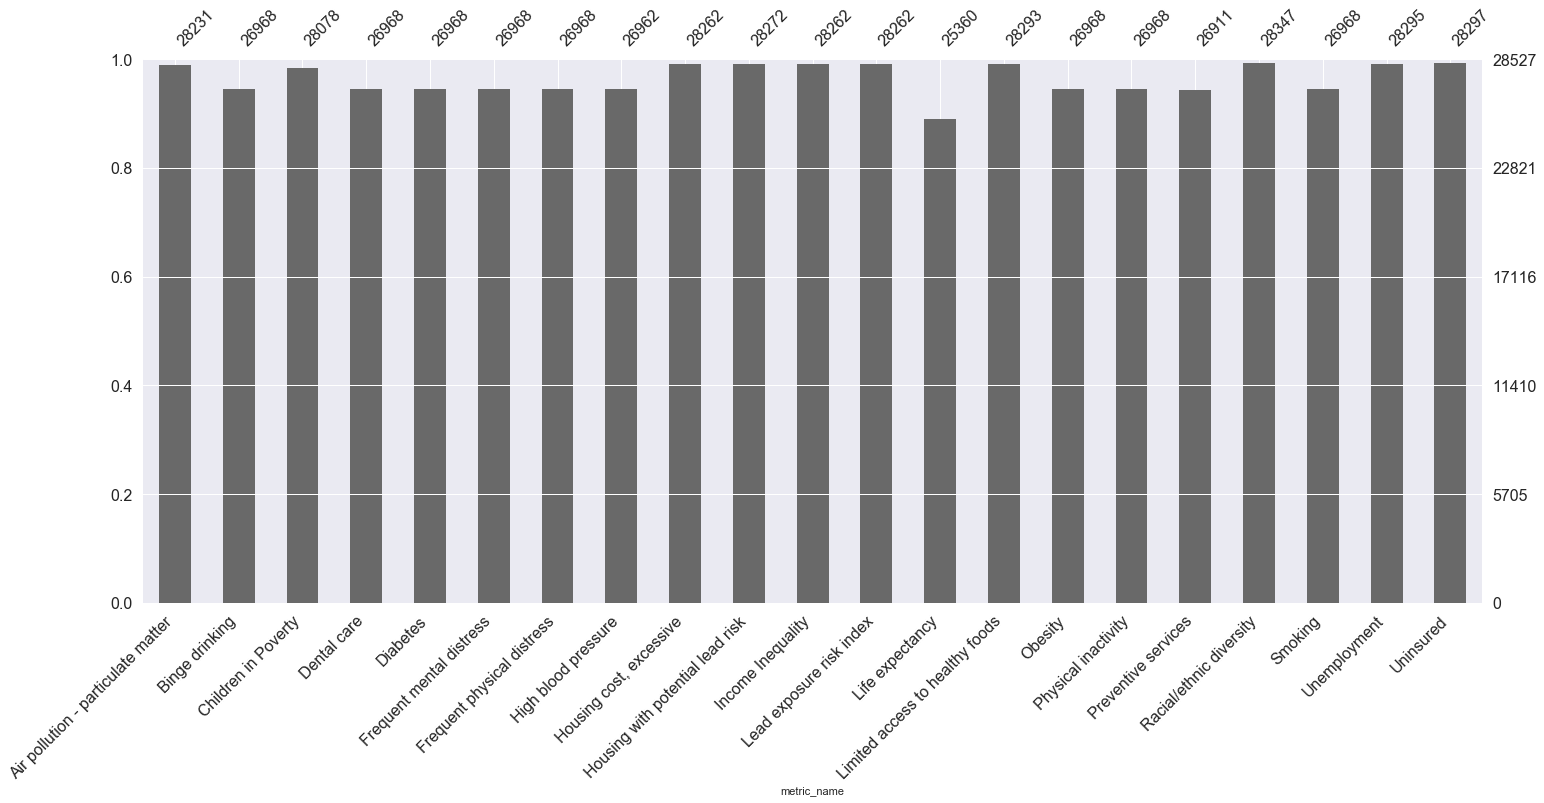

In [0]:
msno.bar(city_table)
plt.show()
msno.bar(tract_table)

# Missing data correlation heatmaps
The below heatmaps show how missing data is related among the variables. 
    <p>A value of -1 means that if one variable appears the other definitely does not. </p>
    <p>A value of 0 means that variables appearing or not appearing have no effect on one another. </p>
    <p>A value of 1 means that if one variable apppears the other definitely also does. </p>

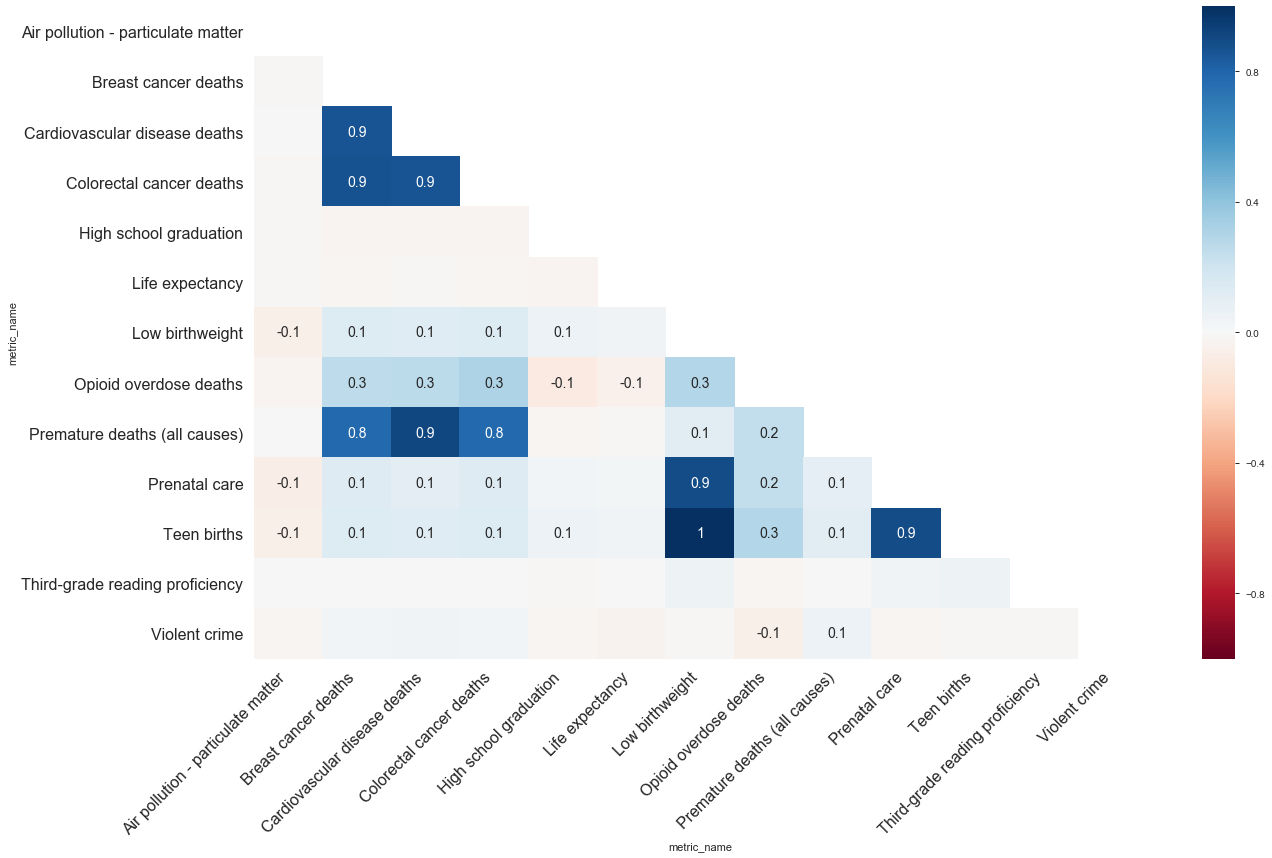

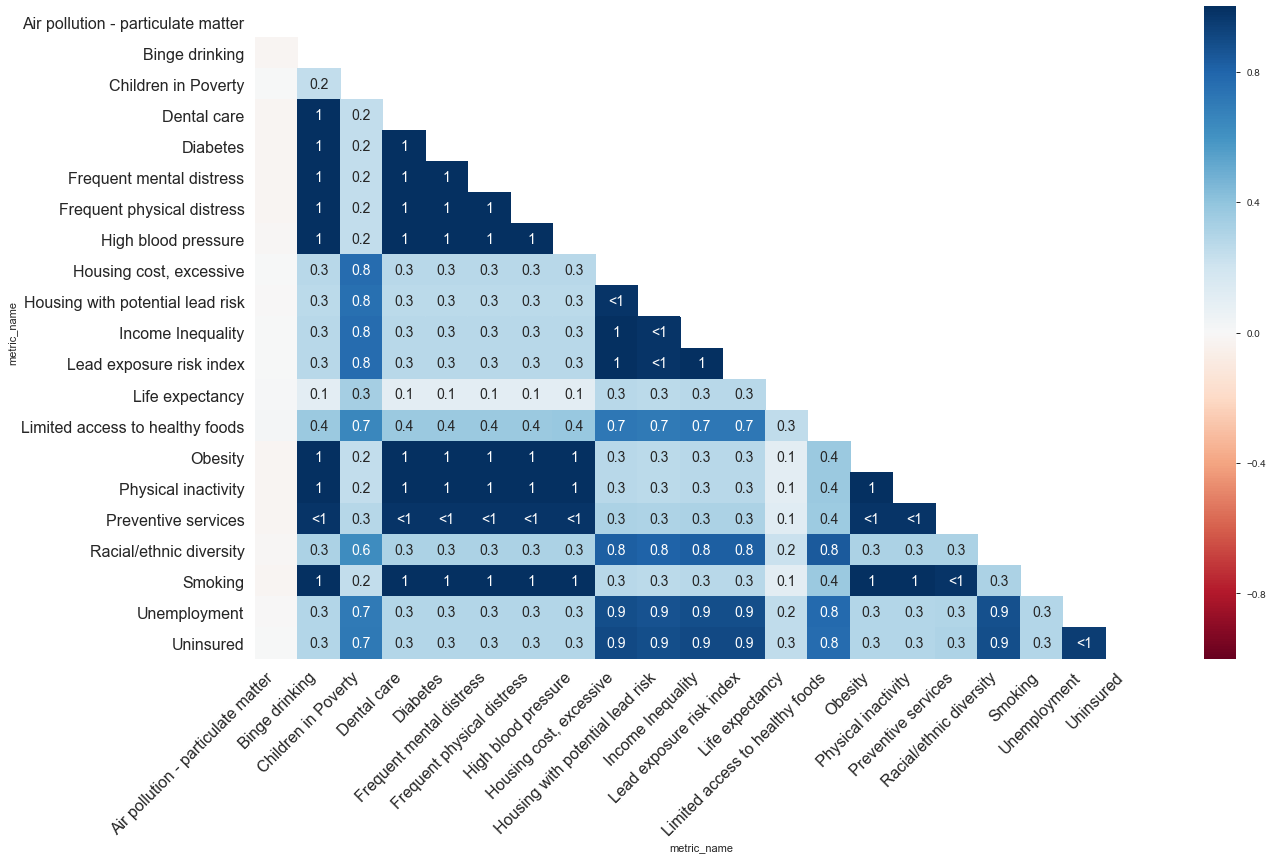

In [0]:
msno.heatmap(city_table)
plt.show()
msno.heatmap(tract_table)

### City table data
Correlated missing values:
Cancer related deaths and premature deaths
if teen births is missing so is low birthweight 100% of the time, prenatal care is pretty close to this

### Tract table data
dental care, diabetes, frequent mental distress, frequent physical distress, high blood pressure, obesity, phyiscal inactivity, preventative services, and smoking
All are predictive of one another that if they are missing data so are the others.

Housing variables (Housing cost, excessive; Housing with potential lead risk, lead exposure risk index, and income inequality)

Looks like most of these would be in places where the dataset comes from the same source, so when they are missing it is because they are missing it from that city for all measures from that single source.


In [0]:
# looking into how Preventative services missing values are related to the others. 
# There was a high correlation between these features as having missing data when 
# the others didn't have missing data with only a few exceptions. But there seems 
# to be quite a bit more exceptions than possible to really attend to myself. 
sub_tract_table = tract_table.loc[:,['Preventive services', 'Binge drinking', 
                                     'Dental care', 'Diabetes',
                                     'Frequent mental distress', 
                                     'Frequent physical distress', 
                                     'High blood pressure', 'Obesity',
                                     'Physical inactivity']]
ps_null = sub_tract_table[sub_tract_table['Preventive services'].isnull()]
bd_notnull = sub_tract_table[sub_tract_table['Binge drinking'].notnull()]
ps_null[sub_tract_table['Binge drinking'].notnull()]

C:\Users\Billy\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


metric_name,Preventive services,Binge drinking,Dental care,Diabetes,Frequent mental distress,Frequent physical distress,High blood pressure,Obesity,Physical inactivity
stcotr_fips,,,,,,,,,
1097003605,NaN,23.9,67.3,1.4,17.3,6.1,9.8,21.8,16.8
1117030212,NaN,22.1,67.1,4.6,12.5,8.1,19.9,34.6,19.1
1125010102,NaN,21.9,73.3,6.9,13.8,11.3,26.8,27.8,19.8
6037265301,NaN,21.1,64.7,1.2,14.3,4.9,6.1,11.7,13.0
6037402404,NaN,31.3,75.9,0.8,12.0,3.7,5.1,11.4,8.7
6071007601,NaN,18.0,34.4,9.6,21.3,17.2,25.3,35.6,32.2
6073003800,NaN,30.0,51.8,2.7,16.3,7.8,8.7,20.4,17.5
6073009901,NaN,25.5,35.8,3.9,21.3,11.9,12.3,26.0,24.5
6073011300,NaN,39.0,72.4,1.5,11.1,4.3,9.7,14.8,10.1


# Dendrogram

Uses hierarchical clustering algorithm to bin variables against one another by their nulity correlation (measured in terms of binary distance)

Cluster leaves which linked together at a distance of zero fully predict one another's presence

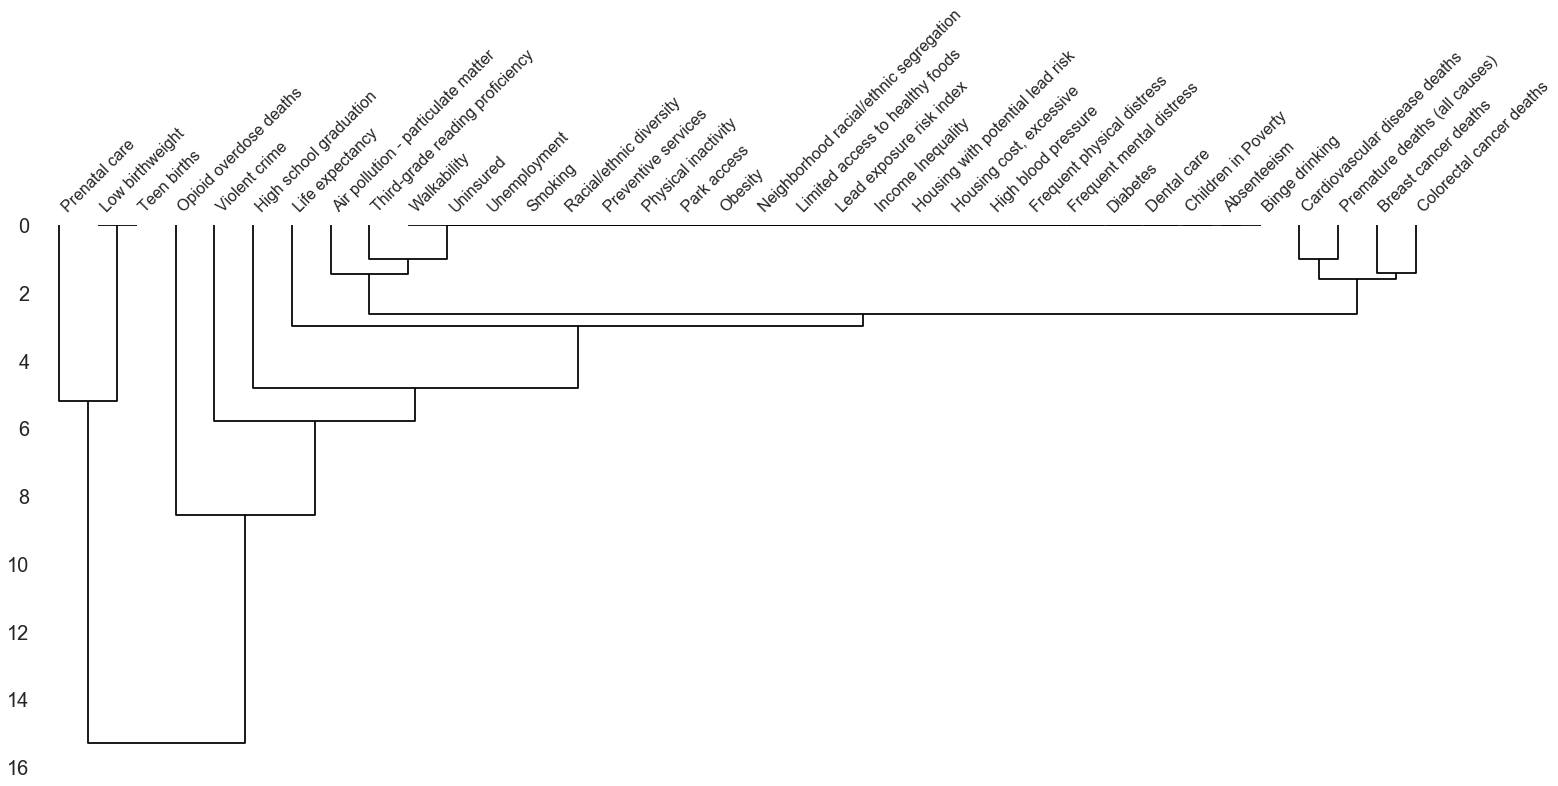

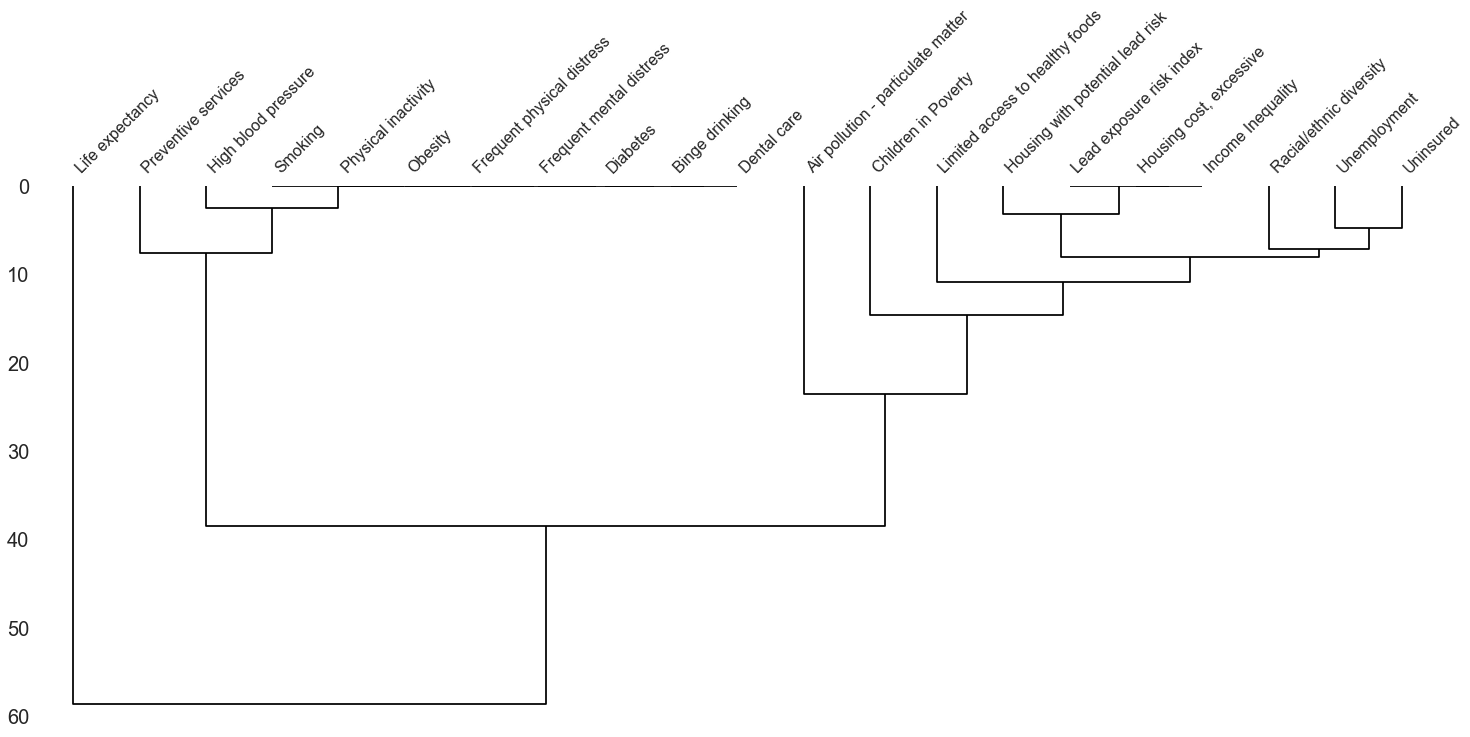

In [0]:
msno.dendrogram(city_table)
plt.show()
msno.dendrogram(tract_table)

A similar conclusion can be drawn from the above trees.

In [0]:
# This makes a really interesting report of the city and the tract data. They can 
# be found on github in the manipulated data folder.
city_profile = city_table.profile_report(title = 'City_profile',style={'full_width':True})
tract_profile = tract_table.profile_report(title= 'Tract_profile',style={'full_width':True})
city_profile.to_file(output_file='../data/manipulated_data/city_output.html')
tract_profile.to_file(output_file='../data/manipulated_data/tract_output.html')

## Removal of missing values

#### City
The following have extremely high rates of missing values (approximately 50%) Therefore, they are just removed from the dataset altogether. There doesn't seem to be a point in imputing all of those data points if half of them are missing. 
<p>- Teen Births</p>
<p>- Prenatal Care</p>
<p>- Low Birthweight</p>

In [0]:
city_table2 = city_table.drop(['Teen births','Prenatal care','Low birthweight'],axis=1)

Strict dropping of all rows that are missing values. The strict dropping of all of the rows of missing data are used in the following steps where I impute using machine learning that takes a completely full dataset with no missing values and places my own missing values into them so that I can then see how well the model has done at imputing the missing values. 

In [0]:
city_table_sdropped = city_table2.dropna()
tract_table_sdropped = tract_table.dropna()
print(len(city_table2))
print(len(city_table_sdropped))
print(len(tract_table))
len(tract_table_sdropped)

500
365
28527


23903

## Computation of missing values

In [0]:
# copy of the dataset where all rows with missing data were dropped from the dataset
x_city = city_table_sdropped.copy()
x_city_missing = x_city.copy()

# The following places random missing values into the dataset at the rate that 
# they were present in the original dataset they are present in about 7.24% of the 
# cells. 
ix = [(row, col) for row in range(x_city_missing.shape[0]) for col in range(x_city_missing.shape[1])]
for row, col in random.sample(ix, int(round(.0724*len(ix)))):
    x_city_missing.iat[row, col] = np.nan

# copy of the dataset where all rows with missing data were dropped from the dataset
x_tract = tract_table_sdropped.copy()
x_tract_missing = x_tract.copy()

# The following places random missing values into the dataset at the rate that 
# they were present in the original dataset they are present in about 3.49% of the
# cells. 
ix2 = [(row, col) for row in range(x_tract_missing.shape[0]) for col in range(x_tract_missing.shape[1])]
for row, col in random.sample(ix2, int(round(.03493532442948785*len(ix2)))):
    x_tract_missing.iat[row, col] = np.nan

In [0]:
# creates a training and testing set for each dataset. The missing and the originally 
# strictly dropped dataset
x_city_tr, x_city_test = train_test_split(x_city_missing,train_size=.8,shuffle=False)
comp_city_tr, comp_city_test = train_test_split(np.array(x_city),train_size=.8,shuffle=False)
x_tract_tr, x_tract_test = train_test_split(x_tract_missing,train_size=.8,shuffle=False)
comp_tract_tr, comp_tract_test = train_test_split(np.array(x_tract),train_size=.8,shuffle=False)

In [0]:
def imputer_scores(estimator, df_miss_tr, df_miss_test, df_full_tr, df_full_test, strategy=None):
  ''' This function tests the machine learning estimator that is imputing values
  for the missing values that were intentionally placed into the data set. It 
  then scores this model based on how well it accurately imputes the real values. 

  args: 
  estimator - machine learning imputer
  df_miss_tr - training dataset with intentionally missing data
  df_miss_test - test dataset with intentionally missing data
  df_full_tr - training dataset where all rows with missing data were strictly dropped
  df_full_test - test dataset where all rows with missing data were strictly dropped
  strategy - the SimpleImputer uses strategies: mean, median to impute values

  returns: mean squared error of training and test predictions
  '''

    if estimator == SimpleImputer:
        model = SimpleImputer(missing_values=np.nan, strategy=strategy)
    else:
        model = estimator()
    model_fit = model.fit(df_miss_tr)
    filled = model_fit.transform(df_miss_tr)
    filled2 = model_fit.transform(df_miss_test)
    tr_mse = mse(df_full_tr,filled)
    test_mse = mse(df_full_test,filled2)
    return('train: '+str(tr_mse), 'test: '+str(test_mse))

#### Simple Imputer

In [0]:
# simple imputer to impute intentional missing values
print(imputer_scores(SimpleImputer, x_city_tr, x_city_test, comp_city_tr, comp_city_test, 
                     strategy='median'))
print(imputer_scores(SimpleImputer, x_city_tr, x_city_test, comp_city_tr, comp_city_test, 
                     strategy='mean'))
print(imputer_scores(SimpleImputer, x_tract_tr, x_tract_test, comp_tract_tr, comp_tract_test, 
                     strategy='median'))
imputer_scores(SimpleImputer, x_tract_tr, x_tract_test, comp_tract_tr, comp_tract_test, 
                     strategy='mean')

('train: 24217.93279265255', 'test: 1455.1982430469072')
('train: 22378.583756006927', 'test: 3229.194508602107')
('train: 6.705187250038584', 'test: 6.383363462515312')


('train: 6.607822744471344', 'test: 6.372496276293653')

#### Iterative Imputer

In [0]:
# iterative imputer to impute intentional missing values
print(imputer_scores(IterativeImputer, x_city_tr,x_city_test, comp_city_tr, comp_city_test))
imputer_scores(IterativeImputer, x_tract_tr,x_tract_test, comp_tract_tr, comp_tract_test)

('train: 2416.0898879383626', 'test: 1468.7676263024716')


('train: 2.7353051982360177', 'test: 2.738506254829637')

#### KNN calculation

In [0]:
# knn calculation to impute intentional missing values
filled_knn = KNN(k=3).fit_transform(x_city_missing)
mse(x_city, filled_knn)

Imputing row 1/365 with 1 missing, elapsed time: 0.168
Imputing row 101/365 with 0 missing, elapsed time: 0.178
Imputing row 201/365 with 1 missing, elapsed time: 0.200
Imputing row 301/365 with 3 missing, elapsed time: 0.216


4664.098417371642

In [0]:
#this crashes my computer. Do NOT run.
# filled_knn2 = KNN(k=3).fit_transform(x_tract_missing)
# mse(x_tract, filled_knn2)

#### SoftImpute

In [0]:
# SoftImpute to impute intentional missing values
x_city_mdropped = x_city_missing.drop('Lead exposure risk index', axis=1)
x_city_dropped = x_city.drop('Lead exposure risk index', axis=1)
city_normalized = BiScaler().fit_transform(np.array(x_city_mdropped))
city_filled_soft = SoftImpute().fit_transform(city_normalized)
mse(np.array(x_city_dropped), city_filled_soft)

[BiScaler] Initial log residual value = 18.385904
[BiScaler] Iter 1: log residual = 1.684069, log improvement ratio=16.701835
[BiScaler] Iter 2: log residual = -0.422564, log improvement ratio=2.106633
[BiScaler] Iter 3: log residual = -2.754835, log improvement ratio=2.332270
[BiScaler] Iter 4: log residual = -5.124278, log improvement ratio=2.369443
[BiScaler] Iter 5: log residual = -7.490799, log improvement ratio=2.366521
[BiScaler] Iter 6: log residual = -9.850345, log improvement ratio=2.359546
[BiScaler] Iter 7: log residual = -12.204017, log improvement ratio=2.353671
[BiScaler] Iter 8: log residual = -14.552757, log improvement ratio=2.348740
[BiScaler] Iter 9: log residual = -16.897095, log improvement ratio=2.344338
[BiScaler] Iter 10: log residual = -19.237344, log improvement ratio=2.340250
[BiScaler] Iter 11: log residual = -21.573736, log improvement ratio=2.336391
[BiScaler] Iter 12: log residual = -23.906472, log improvement ratio=2.332737
[BiScaler] Iter 13: log resid

2141740.398377779

In [0]:
city_table_columns = city_table2.columns
tract_table_columns = tract_table.columns
city_table_index = city_table2.index
tract_table_index = tract_table.index

### Best Imputer appears to be Iterative Imputer

In [0]:
# Using the best imputer (Iterative Imputer) to create a filled table for each dataset
iterative_imp = IterativeImputer()
city_table_filled = iterative_imp.fit_transform(city_table2)
tract_table_filled = iterative_imp.fit_transform(tract_table)
city_filled_df = pd.DataFrame(city_table_filled, columns=city_table_columns, 
                              index=city_table_index)
tract_filled_df = pd.DataFrame(tract_table_filled, columns=tract_table_columns, 
                               index=tract_table_index)
tract_filled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28527 entries, 1073000100 to 56021980801
Data columns (total 21 columns):
Air pollution - particulate matter    28527 non-null float64
Binge drinking                        28527 non-null float64
Children in Poverty                   28527 non-null float64
Dental care                           28527 non-null float64
Diabetes                              28527 non-null float64
Frequent mental distress              28527 non-null float64
Frequent physical distress            28527 non-null float64
High blood pressure                   28527 non-null float64
Housing cost, excessive               28527 non-null float64
Housing with potential lead risk      28527 non-null float64
Income Inequality                     28527 non-null float64
Lead exposure risk index              28527 non-null float64
Life expectancy                       28527 non-null float64
Limited access to healthy foods       28527 non-null float64
Obesity                    

In [0]:
# making the Lead exposure risk index back into a categorical variable
city_filled_df['Lead exposure risk index'] = city_filled_df['Lead exposure risk index'].astype('category')
tract_filled_df['Lead exposure risk index'] = tract_filled_df['Lead exposure risk index'].astype('category')

# Correlation

In [0]:
# splits the dataset so that the correlation maps are actually able to view. 
# When there are too many features it is all really small and hard to read
first_features_city = city_filled_df.iloc[:, :18]
second_features_city = city_filled_df.iloc[:,18:]
first_features_tract = tract_filled_df.iloc[:, :11]
second_features_tract = tract_filled_df.iloc[:, 11:]

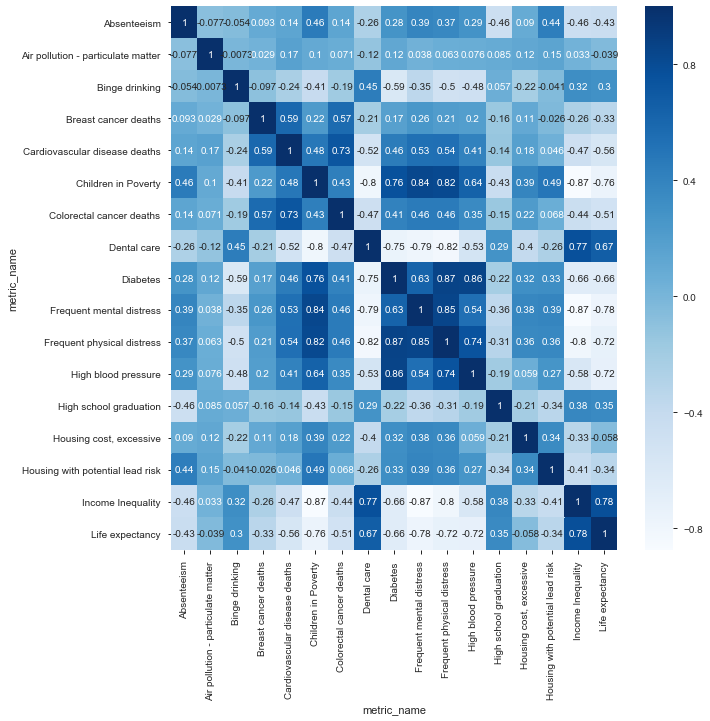

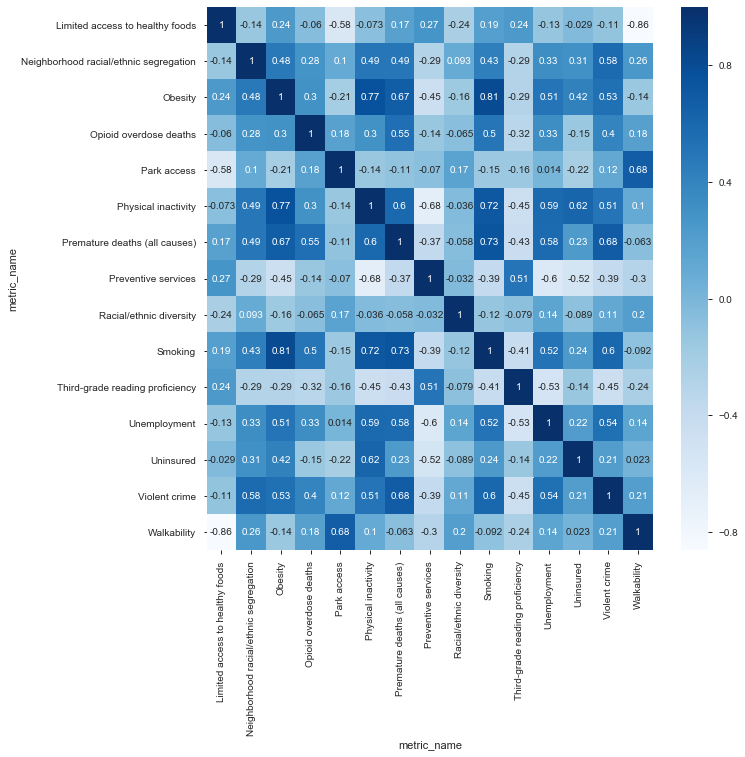

In [0]:
# correlation maps of the city dataset
plt.figure(figsize=(10,10))
sns.heatmap(first_features_city.corr(), cmap='Blues', annot=True)
plt.show()
plt.figure(figsize=(10,10))
sns.heatmap(second_features_city.corr(), cmap='Blues', annot=True)

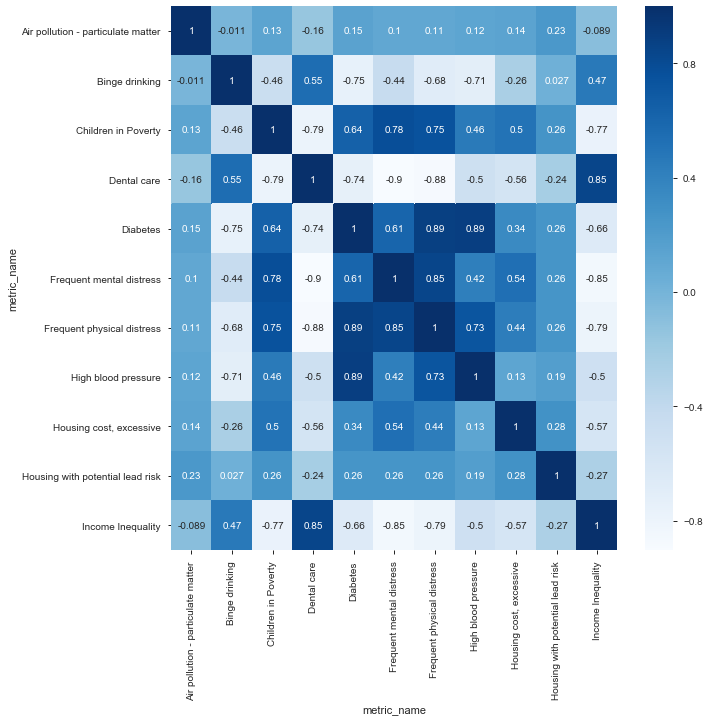

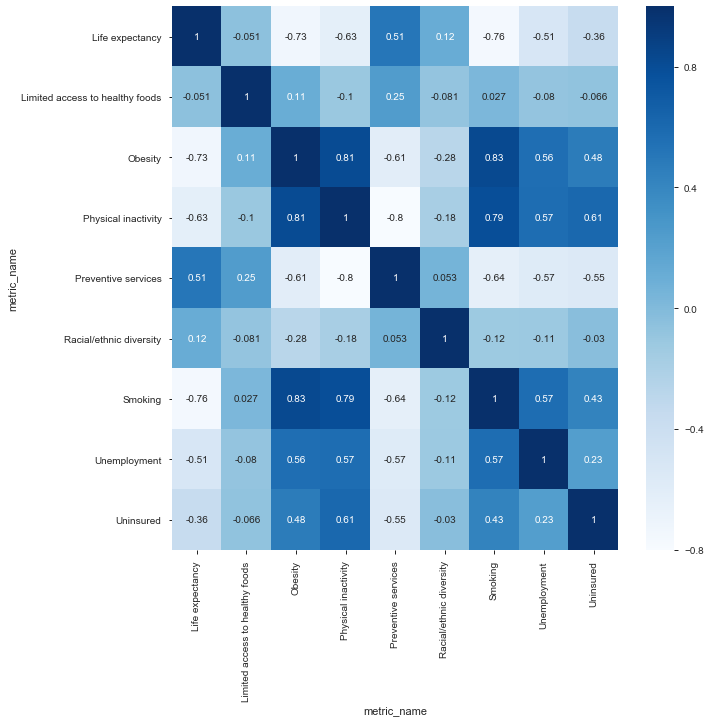

In [0]:
# correlation maps of the tract dataset
plt.figure(figsize=(10,10))
sns.heatmap(first_features_tract.corr(), cmap='Blues', annot=True)
plt.show()
plt.figure(figsize=(10,10))
sns.heatmap(second_features_tract.corr(), cmap='Blues', annot=True)

#### Tract Data
Physical_inactivity is highly correlated with Frequent_physical_distress (ρ = 0.9160439931) 

This wasn't found through the correlation heatmaps, but through the pandas profile that was created previously. 

In [0]:
tract_filled_df2 = tract_filled_df.drop('Frequent physical distress', axis=1)

Some of the predictions used by the missing value iterative index created values for the index that were too high or not appropriate (e.g. decimal numbers. This sets them to an actual number and the numbers that are too high back to 10. 

In [0]:
tract_filled_df2['Lead exposure risk index'] = round(tract_filled_df2['Lead exposure risk index'])
tract_filled_df2['Lead exposure risk index'] = tract_filled_df2['Lead exposure risk index'].replace([11,12,
                                                                                                     14], 10)
tract_filled_df2['Lead exposure risk index'] = tract_filled_df2['Lead exposure risk index'].astype('category')

The Imputer also made values too high or too low. Many of the features are percentages and thus could not be negative or above 100. 

In [0]:
def over100_below0_percent(df, columns, minimum=0, maximum=100):
  ''' This function fixes any imputation errors made by the imputer
  args:
      df - dataframe with imputation errors
      columns - columns that need to be adjusted
      minimum - the minimum value that is possible for the feature
      maximum - the maximum value that is possible for the feature

  returns: *caution* no return, 'fixes' dataframe immediately
  '''
    for col in columns:
        over_below = df[col][(df[col]<0) | (df[col] >100)]
        for idx, value in zip(over_below.index, over_below):
            if value > maximum:
                df.loc[idx, col] = maximum
            if value < minimum:
                df.loc[idx, col] = minimum

In [0]:
# city dataset only had one feature that had an issue
over100_below0_percent(city_filled_df, ['Opioid overdose deaths'])
# tract dataset had 3 that needed to be between 0 and 100 and were either under 
# over or both
over100_below0_percent(tract_filled_df2, ['Children in Poverty',
                                          'Limited access to healthy foods', 
                                          'Uninsured'])
# income inequality is supposed to range from -100 to +100, but there were values 
# above and below this min and max
over100_below0_percent(tract_filled_df2, ['Income Inequality'],minimum=-100, 
                       maximum=100)


# Outliers

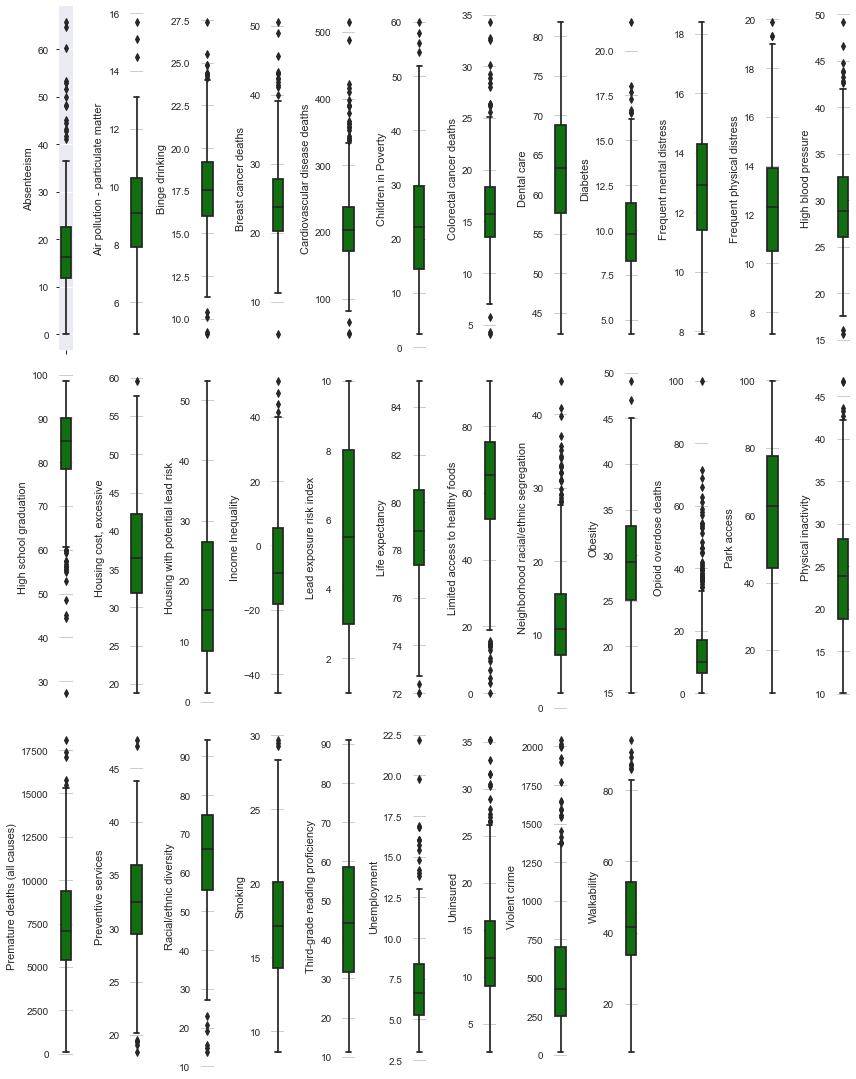

In [0]:
# plots all of the features of the city dataset as boxplots
l = city_filled_df.columns.values
number_of_columns=12
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(city_filled_df[l[i]],color='green',orient='v')
    plt.tight_layout()

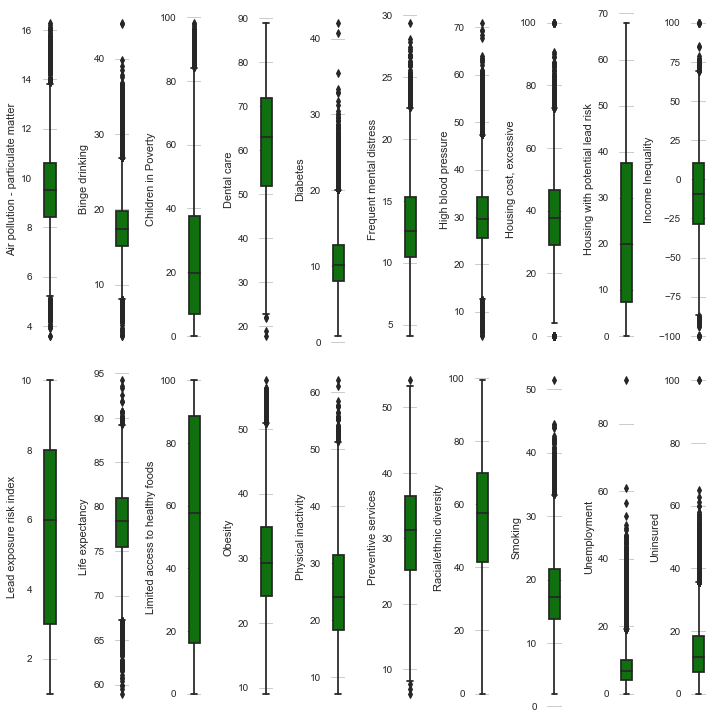

In [0]:
# plots all of the features of the tract dataset as boxplots
l2 = tract_filled_df2.columns.values
number_of_columns2=10
number_of_rows2 = len(l2)-1/number_of_columns2
plt.figure(figsize=(number_of_columns2,5*number_of_rows2))
for i in range(0,len(l2)):
    plt.subplot(number_of_rows2 + 1,number_of_columns2,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(tract_filled_df2[l2[i]],color='green',orient='v')
    plt.tight_layout()

In [0]:
# this gets rid of the Lead Exposure index since it was breaking the outlier functions
city_no_index = city_filled_df.drop('Lead exposure risk index', axis=1)
tract_no_index = tract_filled_df2.drop('Lead exposure risk index', axis=1)

In [0]:
def outliers_per_col(column):
  '''this function determines where the outliers are located in each feature
  args: column - a single column in the dataset
  returns: a boolean series that is true for an outlier
  '''
    lqt, uqt = np.quantile(column, .25), np.quantile(column, .75)
    onehalf = iqr(column) * 1.5
    upper_outlier = uqt + onehalf
    lower_outlier = lqt - onehalf
    outliers_binomial = (column > upper_outlier) | (column < lower_outlier)
    return(outliers_binomial)

In [0]:
def outliers_df_fx(df):
  '''this takes the previous function and puts it into the entire dataset
  args: df - the dataframe
  returns: boolean dataframe where outliers are marked as True
  '''
    new_df = pd.DataFrame()
    for col in df.columns:
        new_col = outliers_per_col(df[col])
        new_df[col] = new_col
    return(new_df)

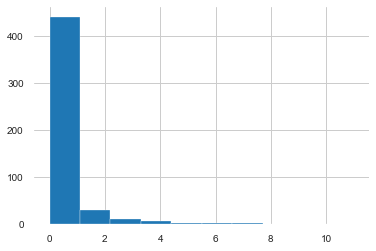

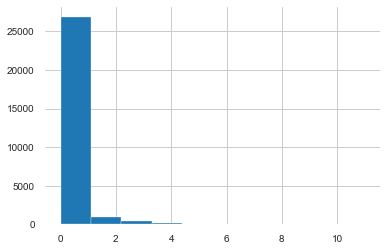

In [0]:
# creation of boolean outlier dataframes
outliers_city_df = outliers_df_fx(city_no_index)
outliers_tract_df = outliers_df_fx(tract_no_index)

# histograms of the outlier dataframes with each location as the count on the 
# y-axis and the number of outliers on the x

#city data
plt.hist(outliers_city_df.sum(axis=1))
plt.title('City Data Outliers')
plt.xlabel('Number of Outliers')
plt.ylabel('Count of Locations')
plt.show()

# Tract data
plt.hist(outliers_tract_df.sum(axis=1))
plt.title('City Data Outliers')
plt.xlabel('Number of Outliers')
plt.ylabel('Count of Locations')
plt.show()

In [0]:
# a series of all of the outliers summed per location
summed_city = outliers_city_df.sum(axis=1)
summed_tract = outliers_tract_df.sum(axis=1)
# a dataframe of all of the outliers summed per location
summed_city_df = pd.DataFrame(summed_city, columns=['Number of Outliers'])
summed_tract_df = pd.DataFrame(summed_tract, columns=['Number of Outliers'])
# added a count digit to groupby in next step
summed_city_df['Number of Cities'] = 1
summed_tract_df['Number of Tracts'] = 1
# grouped the locations by how many outliers they had and summed them
city_grouped = summed_city_df.groupby('Number of Outliers').sum()
tract_grouped = summed_tract_df.groupby('Number of Outliers').sum()
# merged city and tract data together
merged = city_grouped.merge(tract_grouped, how='outer',on='Number of Outliers',sort=True)
# Created a column that tells the percentage of total cities that have the number 
# of outliers
merged.insert(loc=1,column='City Percentage',
              value=(merged['Number of Cities']/500) * 100)
# created a column that tells the percent of all of the features that the location 
# has that are outliers. 
# Basically for a single location what percent of the features does it have that 
# are outliers. 
# A large city may see an outlier for several features purely on the fact that 
# it is just extremely large population size. 
merged.insert(loc=2,column='Percent of total city features',
              value=((merged.index/36) * 100).astype('int'))
# same thing as above just for tracts not city
merged['Tract Percentage'] = (merged['Number of Tracts']/28527)*100
merged['Percent of total Tract features'] = (merged.index/21)*100
merged


,Number of Cities,City Percentage,Percent of total city features,Number of Tracts,Tract Percentage,Percent of total Tract features
Number of Outliers,,,,,,
0,342.0,68.4,0,23811,83.468293,0.000000
1,99.0,19.8,2,3037,10.646055,4.761905
2,31.0,6.2,5,930,3.260069,9.523810
3,11.0,2.2,8,457,1.601991,14.285714
4,6.0,1.2,11,181,0.634487,19.047619
5,3.0,0.6,13,66,0.231360,23.809524
6,3.0,0.6,16,28,0.098153,28.571429
7,3.0,0.6,19,11,0.038560,33.333333
8,NaN,NaN,22,3,0.010516,38.095238


The above table takes a look at the outliers. It shows the cities/tracts that have an outlier in one of their features. The percentages shows how much of the cities/tracts have the given number of outliers. The percent of total features is the number of features that have outliers out of the total number of features. There is one tract that has an outlier for 52 percent of the features, which is an incredibly high amount. 

Were the outliers caused by the imputer?? 

In [0]:
summed_tract_df[summed_tract_df['Number of Outliers'] > 8]

,Number of Outliers,Number of Tracts
stcotr_fips,,
22071004800,11,1
39035114700,9,1
47065001600,10,1


In [0]:
tract_filled_df2[(tract_filled_df2.index == '22071004800') | 
                 (tract_filled_df2.index == '39035114700') |
                 (tract_filled_df2.index == '47065001600')]

metric_name,Air pollution - particulate matter,Binge drinking,Children in Poverty,Dental care,Diabetes,Frequent mental distress,High blood pressure,"Housing cost, excessive",Housing with potential lead risk,Income Inequality,Lead exposure risk index,Life expectancy,Limited access to healthy foods,Obesity,Physical inactivity,Preventive services,Racial/ethnic diversity,Smoking,Unemployment,Uninsured
stcotr_fips,,,,,,,,,,,,,,,,,,,,
22071004800,9.0,11.0,74.522623,22.1,24.4,27.3,53.7,80.3,39.8,-100.0,10.0,65.903959,13.2,52.6,52.6,13.0,14.8,42.0,24.914496,29.4
39035114700,12.0,8.0,86.809926,29.4,29.1,22.7,56.0,61.4,31.6,-86.9,10.0,68.042025,0.0,54.2,54.0,16.1,26.6,39.4,37.300000,7.7
47065001600,9.4,5.5,85.300000,26.9,31.2,24.4,63.1,45.0,21.6,-84.4,10.0,66.300000,58.4,52.4,55.6,15.8,31.3,38.1,25.800000,8.7


In [0]:
tract_table[(tract_table.index == '22071004800') | (tract_table.index == '39035114700') |
                 (tract_table.index == '47065001600')]

metric_name,Air pollution - particulate matter,Binge drinking,Children in Poverty,Dental care,Diabetes,Frequent mental distress,Frequent physical distress,High blood pressure,"Housing cost, excessive",Housing with potential lead risk,...,Lead exposure risk index,Life expectancy,Limited access to healthy foods,Obesity,Physical inactivity,Preventive services,Racial/ethnic diversity,Smoking,Unemployment,Uninsured
stcotr_fips,,,,,,,,,,,,,,,,,,,,,
22071004800,9.0,11.0,NaN,22.1,24.4,27.3,28.2,53.7,80.3,39.8,...,10.0,NaN,13.2,52.6,52.6,13.0,14.8,42.0,NaN,29.4
39035114700,12.0,8.0,NaN,29.4,29.1,22.7,28.2,56.0,61.4,31.6,...,10.0,NaN,0.0,54.2,54.0,16.1,26.6,39.4,37.3,7.7
47065001600,9.4,5.5,85.3,26.9,31.2,24.4,32.7,63.1,45.0,21.6,...,10.0,66.3,58.4,52.4,55.6,15.8,31.3,38.1,25.8,8.7


Answer: outliers do not seem to be caused by imputer, since very few were imputed in these rows.

A different look at the outliers. How many are contained per feature?

In [0]:
city_outliers_features = pd.DataFrame(outliers_city_df.sum(axis=0), columns=['Number of Outliers'])
city_outliers_features['Percent Outliers'] = (city_outliers_features['Number of Outliers']/500) * 100
print(city_outliers_features)
tract_outliers_features = pd.DataFrame(outliers_tract_df.sum(axis=0), columns=['Number of Outliers'])
tract_outliers_features['Percent Outliers'] = (tract_outliers_features['Number of Outliers']/28527) * 100
tract_outliers_features

                                        Number of Outliers  Percent Outliers
Absenteeism                                             15               3.0
Air pollution - particulate matter                       3               0.6
Binge drinking                                          14               2.8
Breast cancer deaths                                    13               2.6
Cardiovascular disease deaths                           23               4.6
Children in Poverty                                      4               0.8
Colorectal cancer deaths                                15               3.0
Dental care                                              0               0.0
Diabetes                                                 7               1.4
Frequent mental distress                                 0               0.0
Frequent physical distress                               3               0.6
High blood pressure                                     10               2.0

,Number of Outliers,Percent Outliers
Air pollution - particulate matter,290,1.016581
Binge drinking,890,3.119851
Children in Poverty,135,0.473236
Dental care,4,0.014022
Diabetes,1123,3.936621
Frequent mental distress,127,0.445192
High blood pressure,1633,5.724401
"Housing cost, excessive",159,0.557367
Housing with potential lead risk,0,0.000000
Income Inequality,77,0.269920


Removing cities and tracts that have more than 1 outlier. 

In [0]:
toomany_city = list(summed_city[summed_city > 1].index)
toomany_tract = list(summed_tract[summed_tract > 1].index)
city_filled_df = city_filled_df.drop(toomany_city, axis=0)
tract_filled_df2 = tract_filled_df2.drop(toomany_tract, axis=0)

In [0]:
# coming to the end of the analysis, now making a second profile to see the 
# changes that were made and if any further need to be done
city_filled_profile = city_filled_df.profile_report(title = 'City_filled_profile',style={'full_width':True})
tract_filled_profile = tract_filled_df2.profile_report(title= 'Tract_filled_profile',
                                                       style={'full_width':True})
city_filled_profile.to_file(output_file='../data/manipulated_data/city_filled_output.html')
tract_filled_profile.to_file(output_file='../data/manipulated_data/tract_filled_output.html')

In [0]:
LERI_city_df = city_filled_df[['Lead exposure risk index']]
LERI_tract_df = tract_filled_df2[['Lead exposure risk index']]

In [0]:
# for further analysis on the HealthScoresML, need just the LERI data
LERI_city_df.to_csv('../data/manipulated_data/leri_city.csv')
LERI_tract_df.to_csv('../data/manipulated_data/leri_tract.csv')

## Scaling

In [0]:
x_tract_tr, x_tract_test = train_test_split(tract_filled_df2, train_size = .8, random_state=42)
x_city_tr, x_city_test = train_test_split(city_filled_df, train_size = .8, random_state=42)

#### Encoding categorical variable first into sparse data

In [0]:
names = []
for i in range(1,11):
    names.append('LERI_' + str(i))

In [0]:
def exposure_enc_fx(df_tr, col):
  ''' creates an encoded variable for LERI data since it is categorical
  args: df_tr - training dataframe
        col - the column to be encoded
  returns: dataframe with column encoded 
  '''
    enc = OneHotEncoder()
    exposure = np.array(df_tr[col]) # need an numpy array
    exposure = exposure.reshape(-1,1) # reshaping array for encoder
    encoded_lead = enc.fit_transform(exposure).toarray()
    LERI_encoded = pd.DataFrame(encoded_lead, columns=names, index=df_tr.index)
    df_tr = df_tr.merge(LERI_encoded, left_index=True, right_index=True)
    df_tr2 = df_tr.drop(col,axis=1) # drop the original column so that only left with encoded columns
    return(df_tr2)

In [0]:
x_tract = exposure_enc_fx(tract_filled_df2, 'Lead exposure risk index')
x_city = exposure_enc_fx(city_filled_df, 'Lead exposure risk index')

Test on features for normality

In [0]:
def shapiro_df_fx(df):
  ''' determines if columns are normally distributed
  args: df - dataframe
  returns: dataframe that contains the statistic and p-value for each test of 
  normality on each column
  '''    
    shapiro_df = pd.DataFrame(index=df.columns)
    for col in df.columns:
        stat, p = shapiro(df[col])
        shapiro_df.loc[col, 'p-value'] = p
        shapiro_df.loc[col, 'Statistic'] = stat
        shapiro_df.loc[col, 'Normal?'] = p > 0.05
    return(shapiro_df)

In [0]:
# performing a baseline normality test before scaling the data
normality_test_city = shapiro_df_fx(x_city)
normality_test_tract = shapiro_df_fx(x_tract)
normality_test_city

,p-value,Statistic,Normal?
Absenteeism,9.135320e-11,0.952074,False
Air pollution - particulate matter,5.200394e-03,0.990278,False
Binge drinking,1.706318e-04,0.985106,False
Breast cancer deaths,2.744849e-02,0.992570,False
Cardiovascular disease deaths,5.497062e-06,0.979056,False
Children in Poverty,1.708202e-04,0.985108,False
Colorectal cancer deaths,7.997279e-02,0.994008,True
Dental care,7.070126e-02,0.993842,True
Diabetes,7.585615e-02,0.993937,True
Frequent mental distress,1.081292e-01,0.994417,True


#### Scalers
Standard Scaler, Normalizer, Quantile Transformer, Robust Scaler, and Power Transformer

In [0]:
def scaler_prep_fx(X):
  ''' creates scaled distributions the array placed in using a variety of methods
  args: X - array of data
  returns: distributions: a list of tuples that contain the name of the 
  scaler and the array of scaled data
  '''
    distributions = [
    ('Unscaled data', X),
    ('standard scaling',
        StandardScaler().fit_transform(X)),
    ('min-max scaling',
        MinMaxScaler().fit_transform(X)),
    ('max-abs scaling',
        MaxAbsScaler().fit_transform(X)),
    ('robust scaling',
        RobustScaler(quantile_range=(25, 75)).fit_transform(X)),
    ('power transformation (Yeo-Johnson)',
     PowerTransformer(method='yeo-johnson').fit_transform(X)),
    ('quantile transformation (gaussian pdf)',
        QuantileTransformer(output_distribution='normal')
        .fit_transform(X)),
    ('quantile transformation (uniform pdf)',
        QuantileTransformer(output_distribution='uniform')
        .fit_transform(X)),
    ('sample-wise L2 normalizing',
        Normalizer().fit_transform(X)),
    ]
    return distributions

In [0]:
def scaler_fx(df, col_idx, scaler_idx):
  ''' scales the column of choice by the scaler of choice
  args: df - dataframe 
  col_idx - integer of the index of the column that is to be scaled
  scaler_idx - integer of the index of the scaler that is to be used to scale the column
  this index corresponds to the location in the distributions list made in the scaler_prep_fx

  returns: two histograms, one of the original data, the second of the scaled data with a 
  title of which scaler was used. 
  '''
    arr = np.array(np.array(df.iloc[:,col_idx]).reshape(-1,1))
    distributions = scaler_prep_fx(arr)
    title, X = distributions[0]
    sctitle, X_sc = distributions[scaler_idx]
    plt.figure(figsize=(16,10))
    plt.subplot(121)
    plt.hist(X)
    plt.title(title)
    plt.ylabel('Count')
    plt.xlabel('Original Values')
    
    plt.subplot(122)
    plt.hist(X_sc)
    plt.title(sctitle)
    plt.xlabel('Scaled Values')
    plt.show()

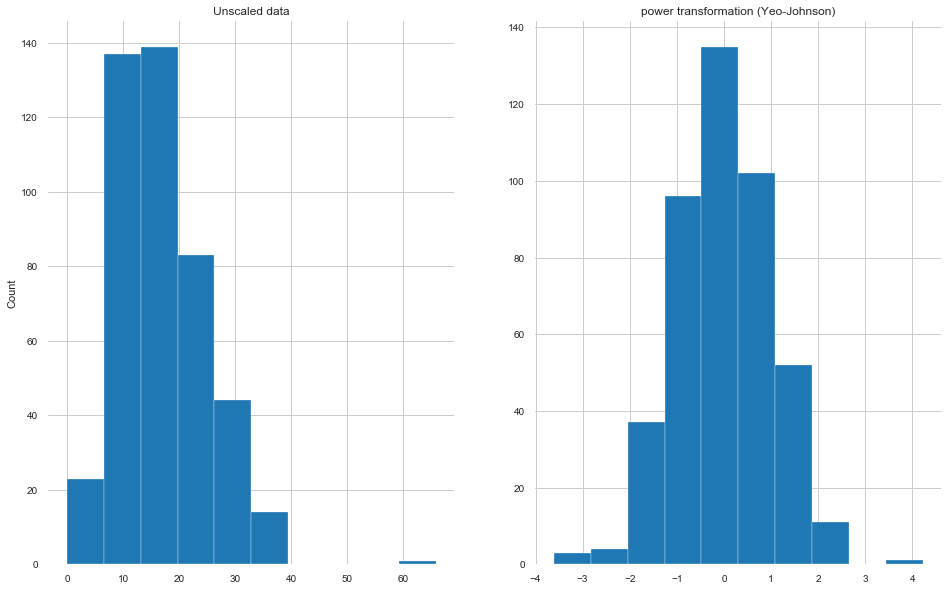

In [0]:
scaler_fx(x_city, 0, 5)

##### Normalization Tests
D'Agostino's (normaltest), shipiro-wilk (shapiro)

In [0]:
# didn't want to scale all features especially the LERI data that was already encoded
city_cols_for_scaling = ['Absenteeism', 'Air pollution - particulate matter', 'Binge drinking',
       'Breast cancer deaths', 'Cardiovascular disease deaths',
       'Children in Poverty', 'Colorectal cancer deaths', 'Dental care',
       'Diabetes', 'Frequent mental distress', 'Frequent physical distress',
       'High blood pressure', 'High school graduation',
       'Housing cost, excessive', 'Housing with potential lead risk',
       'Income Inequality', 'Life expectancy',
       'Limited access to healthy foods',
       'Neighborhood racial/ethnic segregation', 'Obesity',
       'Opioid overdose deaths', 'Park access', 'Physical inactivity',
       'Premature deaths (all causes)', 'Preventive services',
       'Racial/ethnic diversity', 'Smoking', 'Third-grade reading proficiency',
       'Unemployment', 'Uninsured', 'Violent crime', 'Walkability']
tract_cols_for_scaling = ['Air pollution - particulate matter', 'Binge drinking',
       'Children in Poverty', 'Dental care', 'Diabetes',
       'Frequent mental distress', 'High blood pressure',
       'Housing cost, excessive', 'Housing with potential lead risk',
       'Income Inequality', 'Life expectancy',
       'Limited access to healthy foods', 'Obesity', 'Physical inactivity',
       'Preventive services', 'Racial/ethnic diversity', 'Smoking',
       'Unemployment', 'Uninsured']

In [0]:
def scaler_normality_fx(df, cols, normality_test):
  ''' scales every column in the cols argument and tests each resulting column 
              for normalilty
  args: df - dataframe
  cols - columns to be scaled
  normality_test - test to determine normality of the columns

  returns: boolean dataframe that has whether the normality test passed (p>0.05)
              as true
  '''
    p_value_end = pd.DataFrame()
    for col in cols:
        arr = np.array(df[col]).reshape(-1,1)
        distributions = scaler_prep_fx(arr)
        dist_df = pd.DataFrame(distributions, columns=['scalers','values'])
        dist_df = dist_df.set_index('scalers')
        scalers_p_value_df = pd.DataFrame(index=['Normal?']) # can place 'p-value' as another index
        for scale in dist_df.index:
            stat,p = normality_test(dist_df.loc[scale][0].flatten())
            scalers_p_value_df[scale]= [(p>0.05)] # can place p as another value to have in the dataframe
        p_value_label = pd.concat([scalers_p_value_df], keys=[col])
        p_value_end = p_value_end.append(p_value_label)
    return p_value_end   

In [0]:
x_city_no_LERI = x_city.loc[:, city_cols_for_scaling]
x_tract_no_LERI = x_tract.loc[:, tract_cols_for_scaling]

#### Shapiro-Wilkes test for Normality

In [0]:
# using shapiro-wilkes test of normality to determine how many features are 
# normal for the city dataset
x_city_normality = scaler_normality_fx(x_city, city_cols_for_scaling, shapiro)
x_city_normality.sum()

Unscaled data                              8
standard scaling                           8
min-max scaling                            8
max-abs scaling                            8
robust scaling                             8
power transformation (Yeo-Johnson)        18
quantile transformation (gaussian pdf)     0
quantile transformation (uniform pdf)      0
sample-wise L2 normalizing                29
dtype: int64

In [0]:
# using shapiro-wilkes test of normality to determine how many features are 
# normal for the tract dataset
x_tract_normality = scaler_normality_fx(x_tract, tract_cols_for_scaling, shapiro)
x_tract_normality.sum()

Unscaled data                              0
standard scaling                           0
min-max scaling                            0
max-abs scaling                            0
robust scaling                             0
power transformation (Yeo-Johnson)         0
quantile transformation (gaussian pdf)     6
quantile transformation (uniform pdf)      0
sample-wise L2 normalizing                11
dtype: int64

#### D'Agostino's

In [0]:
x_city_normality = scaler_normality_fx(x_city, city_cols_for_scaling, normaltest)
x_city_normality.sum()

Unscaled data                              3
standard scaling                           3
min-max scaling                            3
max-abs scaling                            3
robust scaling                             3
power transformation (Yeo-Johnson)        15
quantile transformation (gaussian pdf)     0
quantile transformation (uniform pdf)      0
sample-wise L2 normalizing                 0
dtype: int64

In [0]:
x_tract_normality = scaler_normality_fx(x_tract, tract_cols_for_scaling, normaltest)
x_tract_normality.sum()

Unscaled data                              0
standard scaling                           0
min-max scaling                            0
max-abs scaling                            0
robust scaling                             0
power transformation (Yeo-Johnson)         2
quantile transformation (gaussian pdf)    12
quantile transformation (uniform pdf)      0
sample-wise L2 normalizing                 0
dtype: int64

These tests really show me that the data is not normal even after scaling. The best scalers in terms of making the most features normal was the power transformation (Yeo-Johnson) for the city data, and the quantile transformation (gaussian pdf) for the tract data. However, this is only really performing well to transform 50% of features. 

#### Scaling Implementation

In [0]:
def scaling_fx(df, scaler, **kwargs):
  ''' takes the dataframe and scales all of the data
  args: df - dataframe
  scaler - the scaler to use on the data
  **kwargs - extra arguments to be placed into scaler function

  returns: a transformed dataframe
  '''
    df_transformed = pd.DataFrame(index = df.index) # blank dataframe to put values in with a supplied index
    for col in df.columns:
        X = np.array(df[col]).reshape(-1,1) # make an array of the data
        scaled = scaler(**kwargs).fit_transform(X) # using scaler and given extra arguments to fit and transform data
        df_transformed[col] = scaled # adding scaled column to the previously blank transformed dataframe
    return df_transformed

In [0]:
# without the already encoded LERI columns, PowerTransformer was used on the city dataset
x_city_scaled = scaling_fx(x_city_no_LERI, PowerTransformer, method= 'yeo-johnson')
x_city_scaled.head()

,Absenteeism,Air pollution - particulate matter,Binge drinking,Breast cancer deaths,Cardiovascular disease deaths,Children in Poverty,Colorectal cancer deaths,Dental care,Diabetes,Frequent mental distress,...,Physical inactivity,Premature deaths (all causes),Preventive services,Racial/ethnic diversity,Smoking,Third-grade reading proficiency,Unemployment,Uninsured,Violent crime,Walkability
stpl_fips,,,,,,,,,,,,,,,,,,,,,
15003,0.006842,-0.499742,-0.020660,-1.055396,-1.229053,-0.988966,-0.967751,1.150052,0.348535,-1.525821,...,-0.202129,-0.580329,-0.518287,1.152400,-0.851995,1.062880,-1.129992,-1.765806,-0.671048,1.346536
135896,-0.826613,1.283283,0.019322,-2.556865,-3.174539,-1.405395,-3.617697,1.446476,-0.642866,-1.120557,...,-0.425576,-1.500167,1.943735,-0.671436,-0.739282,0.387509,-1.341692,-0.980504,-1.703732,-1.547936
137000,1.083484,0.760914,-1.594478,-0.462843,-0.630019,0.853905,-0.450563,-0.405261,1.253025,0.363712,...,0.574289,0.537656,2.040596,-0.304992,0.427710,-0.612991,0.397369,0.228754,1.405747,-1.470870
150000,0.347246,0.706883,-1.311876,1.020147,1.289300,1.420849,1.128082,-0.770914,2.622215,1.087794,...,1.151429,1.693662,-0.425309,-0.446530,0.848538,-1.326623,0.651978,0.530690,1.435534,-0.672563
151000,-0.265029,0.920981,-1.128428,1.852720,0.670747,1.302379,0.662663,-0.492458,1.945752,0.984079,...,1.199458,1.309343,-0.195789,-0.411515,1.041697,-1.521687,0.651978,0.301867,0.710381,-1.149655


In [0]:
#  without the already encoded LERI columns, QuantileTransformer was used on the tract dataset
x_tract_scaled = scaling_fx(x_tract_no_LERI, QuantileTransformer, output_distribution='normal')
x_tract_scaled.head()

,Air pollution - particulate matter,Binge drinking,Children in Poverty,Dental care,Diabetes,Frequent mental distress,High blood pressure,"Housing cost, excessive",Housing with potential lead risk,Income Inequality,Life expectancy,Limited access to healthy foods,Obesity,Physical inactivity,Preventive services,Racial/ethnic diversity,Smoking,Unemployment,Uninsured
stcotr_fips,,,,,,,,,,,,,,,,,,,
1073000100,1.225943,-1.968165,1.858747,-1.475269,1.976943,1.664082,2.074445,0.783330,0.469603,-1.497997,-1.663376,0.819656,2.325972,1.926403,-0.619578,-0.469603,1.773922,0.886449,1.659093
1073000300,1.421556,-1.798663,2.621713,-1.773922,2.456904,1.611333,1.994971,-0.253606,0.182928,-2.246198,-2.408550,1.016672,2.365248,2.225823,-0.981540,0.465405,1.773922,1.264066,1.521525
1073001100,1.421556,-2.043115,0.478025,-0.524976,2.144011,0.313694,2.696511,-0.270485,-0.124523,-0.680013,-1.976943,5.199338,1.761948,1.104747,-0.269184,-2.500459,0.457033,-0.032625,-0.139710
1073002100,1.225943,-1.858747,0.828465,-1.125776,1.756055,1.280981,2.074445,0.621099,0.500651,-1.307063,-1.411293,0.873515,2.053336,1.620592,-0.313694,-1.008294,1.435477,-0.244548,0.805692
1073002200,1.324958,-1.934489,1.212751,-1.186981,2.225823,1.149742,2.393525,0.924252,0.556927,-1.037937,-1.679303,-0.318969,2.235894,1.716415,-0.608973,-1.659093,1.381364,1.684464,1.084195


In [0]:
# reattaching the LERI columns
leri = ['LERI_1', 'LERI_2', 'LERI_3', 'LERI_4','LERI_5', 'LERI_6', 'LERI_7', 'LERI_8', 'LERI_9', 'LERI_10']
x_city_leri = x_city.loc[:,leri]
x_tract_leri = x_tract.loc[:, leri]
x_city_scaled2 = x_city_scaled.merge(x_city_leri, how='outer', left_index=True, right_index=True)
x_tract_scaled2 = x_tract_scaled.merge(x_tract_leri, how='outer', left_index=True, right_index=True)

In [0]:
# saving the dataframes into csv files
x_city.to_csv('../data/manipulated_data/city_data_manip.csv')
x_tract.to_csv('../data/manipulated_data/tract_data_manip.csv')
x_city_scaled2.to_csv('../data/manipulated_data/city_data_scaled.csv')
x_tract_scaled2.to_csv('../data/manipulated_data/tract_data_scaled.csv')

## Statistics

In [0]:
# just a quick look at the dataset in terms of descriptive statistics after the
# adjustments have been made
print(city_filled_df.describe())
tract_filled_df2.describe()

metric_name  Absenteeism  Air pollution - particulate matter  Binge drinking  \
count         441.000000                          441.000000      441.000000   
mean           16.984807                            9.152350       17.890703   
std             7.831183                            1.710655        2.529612   
min             0.000000                            4.900000       10.100000   
25%            11.500000                            7.900000       16.300000   
50%            15.500000                            9.100000       17.700000   
75%            21.700000                           10.300000       19.400000   
max            65.800000                           15.700000       27.400000   

metric_name  Breast cancer deaths  Cardiovascular disease deaths  \
count                  441.000000                     441.000000   
mean                    23.920737                     203.301444   
std                      5.381747                      48.306949   
min    

metric_name,Air pollution - particulate matter,Binge drinking,Children in Poverty,Dental care,Diabetes,Frequent mental distress,High blood pressure,"Housing cost, excessive",Housing with potential lead risk,Income Inequality,Life expectancy,Limited access to healthy foods,Obesity,Physical inactivity,Preventive services,Racial/ethnic diversity,Smoking,Unemployment,Uninsured
count,26848.000000,26848.000000,26848.000000,26848.000000,26848.000000,26848.000000,26848.000000,26848.000000,26848.000000,26848.000000,26848.000000,26848.000000,26848.000000,26848.000000,26848.000000,26848.000000,26848.000000,26848.000000,26848.000000
mean,9.390352,17.907918,22.404873,62.509196,10.304699,12.777098,29.693813,37.648409,22.756526,-6.038246,78.455692,52.832576,29.297989,24.543652,31.423920,56.058063,17.515780,7.315548,13.243854
std,1.602414,3.728107,18.774862,12.040289,3.416520,3.138588,6.743886,12.187907,17.267573,26.560938,3.877168,36.743381,7.185656,8.395614,7.028937,19.076080,5.421408,4.679051,8.775424
min,3.600000,6.800000,0.000000,25.400000,1.100000,5.200000,6.400000,0.000000,0.000000,-86.800000,59.000000,0.000000,9.800000,7.100000,9.100000,0.000000,4.800000,0.000000,0.000000
25%,8.300000,15.500000,6.300000,53.700000,7.900000,10.400000,25.449572,28.700000,7.000000,-25.300000,75.900000,15.700000,24.000000,18.100000,26.100000,43.500000,13.500000,4.000000,6.700000
50%,9.400000,17.500000,18.300000,64.000000,9.915713,12.400000,29.300000,37.000000,18.700000,-7.900000,78.600088,57.350000,28.800000,23.500000,31.700000,58.100000,17.000000,6.300000,11.400000
75%,10.500000,19.900000,35.200000,72.100000,12.254526,14.900000,33.400000,45.800000,36.800000,11.800000,81.100000,88.000000,33.900000,30.100000,36.700000,70.500000,20.800000,9.400000,17.900000
max,16.300000,36.800000,97.400000,88.900000,23.500000,23.600000,55.600000,100.000000,68.000000,84.700000,94.200000,100.000000,53.200000,53.400000,54.100000,99.200000,39.200000,49.100000,59.900000


### Hypothesis

If features are normalized, weighted and scored, then they will be classified into groups that will be a useful tool for classifying a city as healthy or unhealthy. 